3.1 Bonus Stage: Model with Attention
====


In [4]:
# Imports we need.
import random
import pickle

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [5]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

# Reads the tab-delimited data using Pandas.
kopitiam = pd.read_csv('kopitiam.tsv', sep='\t')
kopitiam.head()

,Local Terms,Meaning,Source
0,Kopi O,Black Coffee with Sugar,https://daneshd.com/2010/02/28/a-rough-guide-t...
1,Kopi,Black Coffee with Condensed Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
2,Kopi C,Black Coffee with Evaporated Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
3,Kopi Kosong,Black Coffee without sugar or milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
4,Kopi Gah Dai,Black Coffee with extra condensed milk,https://daneshd.com/2010/02/28/a-rough-guide-t...


In [9]:
# Instead of reinitializing and hoping that the hashes matches, 
# we can simply load the dictionary pickle.

START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1
UNK, UNK_IDX = 'UNK', 2 # Unknown words (currently not use in this model...)


singlish_sents = [START] + kopitiam['Local Terms'].apply(str.lower).apply(word_tokenize) + [END]
english_sents = [START] + kopitiam['Meaning'].apply(str.lower).apply(word_tokenize) + [END]

"""
english_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
english_vocab.add_documents(english_sents)

singlish_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
singlish_vocab.add_documents(singlish_sents)
"""

with open('singlish_vocab.Dictionary.pkl', 'rb') as fin:
    singlish_vocab = pickle.load(fin)
    
with open('english_vocab.Dictionary.pkl', 'rb') as fin:
    english_vocab = pickle.load(fin)
    

def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END])

def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    return result.cuda() if use_cuda else result

# Prepare the whole training corpus.
singlish_tensors = kopitiam['Local Terms'].apply(lambda s: variable_from_sent(s, singlish_vocab))
english_tensors = kopitiam['Meaning'].apply(lambda s: variable_from_sent(s, english_vocab))

# Now, each item in `sent_pairs` is our data point. 
sent_pairs = list(zip(singlish_tensors, english_tensors))

Attention Decoder
----

(**Note:** the following content and code for the attention decoder are from http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called `attn_applied` in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![](https://i.imgur.com/1152PYf.png)

Calculating the attention weights is done with another feed-forward layer `attn`, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![](http://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [38]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        embedded = self.embedding(input).view(1, 1, -1)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of output (i.e. no. of words in output vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Set the output layer to output a specific symbol 
        # from the output vocabulary
        self.softmax = nn.LogSoftmax(dim=1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        output = self.embedding(input).view(1, 1, -1)
        # Transform the embedded output with a relu function. 
        output = F.relu(output)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(output, hidden)
        # Take the updated output and find the most appropriate
        # output symbol. 
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

In [17]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 20

def train_one_epoch(input_variable, target_variable, encoder, decoder, 
                    encoder_optimizer, decoder_optimizer, criterion):
    """
    Function to put the variables, decoder and optimizers to train per epoch.
    """
    encoder_hidden = encoder.initialize_hidden_states()

    # (Re-)Initialize the optimizers, clear all gradients. 
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Initialize the length of the PyTorch variables.
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    
    # Iterating through each word in the input.
    for ei in range(input_length):
        # We move forward through each state.
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        # And we save the encoder outputs. 
        encoder_outputs[ei] = encoder_output[0][0]


    decoder_input = Variable(torch.LongTensor([[START_IDX]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input.
        for di in range(target_length):
            # We add the encoder_outputs for attention to the decoder forward step.
            # And expect it to return the decoder attention.
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                         decoder_hidden, 
                                                                         encoder_outputs) 
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # We add the encoder_outputs for attention to the decoder forward step.
            # And expect it to return the decoder attention.
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                         decoder_hidden, 
                                                                         encoder_outputs) 
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == END_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length


#########################################################
# Some Logging and Plotting Candies to Monitor Training
#########################################################

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


#########################################################
# Top-level function to start the training,
# iterates across epochs.
#########################################################

def train(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [random.choice(sent_pairs) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train_one_epoch(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

0m 1s (- 26m 27s) (100 0%) 3.2681
0m 3s (- 28m 0s) (200 0%) 2.3849
0m 4s (- 26m 27s) (300 0%) 2.2166
0m 6s (- 25m 33s) (400 0%) 2.2512
0m 7s (- 25m 4s) (500 0%) 2.2565
0m 9s (- 25m 27s) (600 0%) 2.0700
0m 10s (- 25m 13s) (700 0%) 2.1847
0m 12s (- 24m 54s) (800 0%) 2.0570
0m 13s (- 24m 44s) (900 0%) 2.0454
0m 14s (- 24m 30s) (1000 1%) 1.8758
0m 16s (- 24m 12s) (1100 1%) 1.7910
0m 17s (- 24m 37s) (1200 1%) 1.7220
0m 19s (- 24m 28s) (1300 1%) 1.7324
0m 20s (- 24m 17s) (1400 1%) 1.6285
0m 22s (- 24m 12s) (1500 1%) 1.5013
0m 23s (- 24m 8s) (1600 1%) 1.4335
0m 25s (- 24m 8s) (1700 1%) 1.4817
0m 26s (- 24m 0s) (1800 1%) 1.4627
0m 27s (- 23m 54s) (1900 1%) 1.5118
0m 29s (- 23m 49s) (2000 2%) 1.4920
0m 30s (- 23m 44s) (2100 2%) 1.3284
0m 32s (- 23m 45s) (2200 2%) 1.1953
0m 34s (- 24m 28s) (2300 2%) 1.2125
0m 36s (- 25m 0s) (2400 2%) 1.3198
0m 39s (- 25m 31s) (2500 2%) 1.3151
0m 41s (- 25m 40s) (2600 2%) 1.2915
0m 42s (- 25m 42s) (2700 2%) 1.1152
0m 44s (- 25m 46s) (2800 2%) 1.2294
0m 46s (- 25m

6m 42s (- 23m 5s) (22500 22%) 0.2937
6m 44s (- 23m 5s) (22600 22%) 0.3780
6m 46s (- 23m 3s) (22700 22%) 0.2737
6m 48s (- 23m 1s) (22800 22%) 0.4909
6m 49s (- 23m 0s) (22900 22%) 0.3049
6m 51s (- 22m 57s) (23000 23%) 0.4517
6m 53s (- 22m 56s) (23100 23%) 0.3892
6m 55s (- 22m 54s) (23200 23%) 0.2867
6m 56s (- 22m 51s) (23300 23%) 0.2874
6m 58s (- 22m 49s) (23400 23%) 0.3210
6m 59s (- 22m 47s) (23500 23%) 0.3822
7m 1s (- 22m 45s) (23600 23%) 0.3622
7m 3s (- 22m 42s) (23700 23%) 0.3289
7m 4s (- 22m 40s) (23800 23%) 0.2977
7m 6s (- 22m 39s) (23900 23%) 0.4064
7m 8s (- 22m 37s) (24000 24%) 0.3294
7m 10s (- 22m 35s) (24100 24%) 0.4370
7m 11s (- 22m 32s) (24200 24%) 0.3622
7m 13s (- 22m 30s) (24300 24%) 0.3257
7m 15s (- 22m 28s) (24400 24%) 0.2928
7m 16s (- 22m 26s) (24500 24%) 0.3497
7m 18s (- 22m 23s) (24600 24%) 0.3398
7m 19s (- 22m 21s) (24700 24%) 0.4039
7m 21s (- 22m 18s) (24800 24%) 0.4295
7m 23s (- 22m 16s) (24900 24%) 0.3952
7m 24s (- 22m 13s) (25000 25%) 0.5070
7m 26s (- 22m 11s) (25

12m 51s (- 16m 21s) (44000 44%) 0.2892
12m 52s (- 16m 18s) (44100 44%) 0.3978
12m 53s (- 16m 16s) (44200 44%) 0.4015
12m 55s (- 16m 14s) (44300 44%) 0.3424
12m 56s (- 16m 12s) (44400 44%) 0.3380
12m 58s (- 16m 10s) (44500 44%) 0.3093
12m 59s (- 16m 8s) (44600 44%) 0.3525
13m 1s (- 16m 6s) (44700 44%) 0.3696
13m 2s (- 16m 4s) (44800 44%) 0.3497
13m 4s (- 16m 2s) (44900 44%) 0.3569
13m 5s (- 15m 59s) (45000 45%) 0.3904
13m 6s (- 15m 57s) (45100 45%) 0.2916
13m 8s (- 15m 55s) (45200 45%) 0.3776
13m 9s (- 15m 53s) (45300 45%) 0.3403
13m 10s (- 15m 50s) (45400 45%) 0.3516
13m 12s (- 15m 48s) (45500 45%) 0.3621
13m 13s (- 15m 46s) (45600 45%) 0.3841
13m 14s (- 15m 44s) (45700 45%) 0.3541
13m 16s (- 15m 42s) (45800 45%) 0.3647
13m 17s (- 15m 39s) (45900 45%) 0.4593
13m 18s (- 15m 37s) (46000 46%) 0.3727
13m 20s (- 15m 35s) (46100 46%) 0.3205
13m 21s (- 15m 33s) (46200 46%) 0.3516
13m 22s (- 15m 31s) (46300 46%) 0.3579
13m 24s (- 15m 29s) (46400 46%) 0.3195
13m 25s (- 15m 27s) (46500 46%) 0.36

17m 52s (- 9m 30s) (65300 65%) 0.3401
17m 54s (- 9m 28s) (65400 65%) 0.3663
17m 55s (- 9m 26s) (65500 65%) 0.3955
17m 57s (- 9m 24s) (65600 65%) 0.3890
17m 58s (- 9m 22s) (65700 65%) 0.2427
17m 59s (- 9m 21s) (65800 65%) 0.4044
18m 1s (- 9m 19s) (65900 65%) 0.2719
18m 2s (- 9m 17s) (66000 66%) 0.3753
18m 4s (- 9m 16s) (66100 66%) 0.3541
18m 5s (- 9m 14s) (66200 66%) 0.3373
18m 6s (- 9m 12s) (66300 66%) 0.3431
18m 8s (- 9m 10s) (66400 66%) 0.2559
18m 9s (- 9m 8s) (66500 66%) 0.2783
18m 10s (- 9m 6s) (66600 66%) 0.3343
18m 12s (- 9m 5s) (66700 66%) 0.4015
18m 13s (- 9m 3s) (66800 66%) 0.2483
18m 14s (- 9m 1s) (66900 66%) 0.3127
18m 16s (- 8m 59s) (67000 67%) 0.2873
18m 17s (- 8m 58s) (67100 67%) 0.3049
18m 18s (- 8m 56s) (67200 67%) 0.2873
18m 20s (- 8m 54s) (67300 67%) 0.3042
18m 21s (- 8m 52s) (67400 67%) 0.3032
18m 23s (- 8m 51s) (67500 67%) 0.3399
18m 25s (- 8m 49s) (67600 67%) 0.3107
18m 27s (- 8m 48s) (67700 67%) 0.3424
18m 28s (- 8m 46s) (67800 67%) 0.4269
18m 30s (- 8m 44s) (6790

23m 5s (- 3m 25s) (87100 87%) 0.2709
23m 7s (- 3m 23s) (87200 87%) 0.3178
23m 8s (- 3m 22s) (87300 87%) 0.3869
23m 9s (- 3m 20s) (87400 87%) 0.3430
23m 11s (- 3m 18s) (87500 87%) 0.3198
23m 12s (- 3m 17s) (87600 87%) 0.2793
23m 14s (- 3m 15s) (87700 87%) 0.3079
23m 15s (- 3m 13s) (87800 87%) 0.2248
23m 17s (- 3m 12s) (87900 87%) 0.3841
23m 18s (- 3m 10s) (88000 88%) 0.2698
23m 19s (- 3m 9s) (88100 88%) 0.3175
23m 21s (- 3m 7s) (88200 88%) 0.2413
23m 22s (- 3m 5s) (88300 88%) 0.3461
23m 24s (- 3m 4s) (88400 88%) 0.3644
23m 25s (- 3m 2s) (88500 88%) 0.2558
23m 26s (- 3m 1s) (88600 88%) 0.3850
23m 28s (- 2m 59s) (88700 88%) 0.2992
23m 29s (- 2m 57s) (88800 88%) 0.3290
23m 30s (- 2m 56s) (88900 88%) 0.2952
23m 32s (- 2m 54s) (89000 89%) 0.2499
23m 33s (- 2m 52s) (89100 89%) 0.2693
23m 35s (- 2m 51s) (89200 89%) 0.2924
23m 36s (- 2m 49s) (89300 89%) 0.3234
23m 37s (- 2m 48s) (89400 89%) 0.3541
23m 39s (- 2m 46s) (89500 89%) 0.3426
23m 40s (- 2m 44s) (89600 89%) 0.2987
23m 41s (- 2m 43s) (89

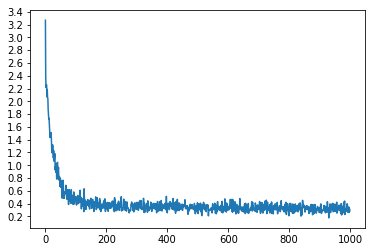

In [18]:
MAX_LENGTH = 20
batches = 100000 # In this case, the PyTorch train_per_epoch() and train() code is using batch_size=1
hidden_size = 100

my_encoder = EncoderRNN(len(singlish_vocab), hidden_size)
my_decoder = AttnDecoderRNN(hidden_size, len(english_vocab))

if use_cuda:
    my_encoder = my_encoder.cuda()
    my_decoder = my_decoder.cuda()


# Load the pre-trained model with teacher forcing.
"""
with open('encoder_attention_100_100000_0.5.pkl', 'rb') as fin:
    my_encoder = pickle.load(fin)
    
with open('decoder_attention_100_100000_0.5.pkl', 'rb') as fin:
    my_decoder = pickle.load(fin)
"""

# Or train a new model; un-comment the following lines

train(my_encoder, my_decoder, batches, print_every=100)
# In Python >= 3.6
with open(f'encoder_attention_{hidden_size}_{batches}_teacher_forcing_ratio.pkl', 'wb') as fout:
    pickle.dump(my_encoder, fout)
with open(f'decoder_attention_{hidden_size}_{batches}_teacher_forcing_ratio.pkl', 'wb') as fout:
    pickle.dump(my_decoder, fout)


In [21]:
MAX_LENGTH = 20

def translator(encoder, decoder, input_variable, max_length=MAX_LENGTH):
    # The length of the input.
    input_length = input_variable.size()[0]
    # For each sentence, initilize the hidden states with zeros.
    encoder_hidden = encoder.initialize_hidden_states()
    # Initialize the encoder outputs. 
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    # Iterate through the input words.
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
    # Initialize the decoder with the start symbol <s>.
    decoder_input = Variable(torch.LongTensor([[START_IDX]])) 
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    # Use the last encoder hidden state as the first decoder's hidden state.
    decoder_hidden = encoder_hidden
    # Keep a list of the decoded words.
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Iterate through the decoder states.
    for di in range(max_length):
        # Very similar to how the training works.
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                    decoder_hidden,
                                                                    encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == END_IDX:
            decoded_words.append(END_IDX)
            break
        else:
            decoded_words.append(ni)
        # Replace the new decoder input for the next state 
        # with the top guess of this state.
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    return decoded_words, decoder_attentions[:di + 1]

    
def translate(kopi_order):
    output_words, _ = translator(my_encoder, my_decoder, variable_from_sent(kopi_order, singlish_vocab))
    output_sentence = [english_vocab[i] for i in output_words[1:output_words.index(1)]]
    return ' '.join(output_sentence)

In [22]:
translate('teh c')

'tea with evaporated milk and sugar'

In [23]:
translate('teh ga dai')

'tea with more sugar'

In [24]:
translate('teh c ga dai')

'hot tea with evaporated milk and more sugar'

In [25]:
translate('teh c ga dai peng')

'iced tea with evaporated milk and more sugar'

In [26]:
translate('teh o siew dai')

'tea with less sugar'

In [27]:
translate('teh tiloh')

'heaviest , purest version of tea with no water added at all to the initial brew'

In [28]:
translate('tak kiu peng')

'iced milo'

In [29]:
translate('tak kiu gau peng')

'strong iced milo'

In [30]:
translate('michael jackson')

'soya bean milk mixed with grass jelly'

In [31]:
translate('michael jackson peng')

'iced strong iced with condensed milk and sugar'

In [32]:
translate('teh siew dai peng')

'iced tea with condensed'

In [33]:
translate('kopi peng gau')

'strong iced coffee of coffee'

In [34]:
translate('kopi gau peng')

'strong iced coffee with condensed milk'

In [35]:
translate('kopi o gau peng')

'strong black coffee with sugar'

In [36]:
translate('kopi o gau siew dai')

'hot black coffee with more coffee powder and lesser sugar'

In [37]:
translate('kopi dinosaur gau siew dai')

'hot coffee with condensed milk and lesser coffee powder and lesser sugar'